In [1]:
import os
import sys
import yaml
import dask
import zarr
import numpy as np
import xesmf as xe
import xarray as xr
import pandas as pd
from glob import glob
# from dask.utils import SerializableLock

# import calendar
from datetime import datetime, timedelta
# from dateutil.relativedelta import relativedelta

# sys.path.insert(0, os.path.realpath('../libs/'))
# import verif_utils as vu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 1000.,  950.,  850.,  700.,  600.,  500.,  400.,  300.,  200.,  100., 50.

In [4]:
import re

def select_fn_fmt(fn_fmt_list, year):
    """
    Return (ind_year, fn_fmt) where fn_fmt_list[ind_year] covers `year`.
    Filenames must contain ranges like ...YYYYMMDDHH-YYYYMMDDHH.nc
    """
    for i, s in enumerate(fn_fmt_list):
        m = re.search(r'(\d{4})\d{4}-(\d{4})\d{4}\.nc$', s)
        if not m:
            continue
        start, end = map(int, m.groups())
        if start <= year <= end:
            return i, s
    raise ValueError(f"No filename pattern covers year {year}.")

In [5]:
# C404 static
static_WRF_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_WRF_static = xr.open_zarr(static_WRF_name)
XLAT = ds_WRF_static['XLAT'].values
XLONG = ds_WRF_static['XLONG'].values
ds_WRF_static = ds_WRF_static.assign_coords(lat=(("south_north", "west_east"), XLAT))
ds_WRF_static = ds_WRF_static.assign_coords(lon=(("south_north", "west_east"), XLONG))
domain_inds = np.arange(336).astype(np.float32)

In [6]:
static_cesm = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static_cesm/ERA5_mlevel_cesm_static.zarr'
ds_cesm_static = xr.open_zarr(static_cesm)
ds_cesm_static = ds_cesm_static.rename({'longitude': 'lon', 'latitude': 'lat'})
ds_cesm_static = ds_cesm_static.sortby('lat')

In [7]:
levels_hPa = [1000, 950, 850, 700, 600, 500, 400, 300, 200, 100, 50]
levels_Pa = np.array(levels_hPa, dtype=np.int32) * 100  # Pa

RDGAS = 287.05   # J/kg/K
GRAVITY = 9.80665
LAPSE_RATE = 0.0065 # K/m
ALPHA = LAPSE_RATE * RDGAS / GRAVITY # ≈ 0.19026
target_height = 2.0  # meters

In [8]:
# 2025, 2035

In [10]:
year = 1980

base_dir = "/gdex/data/d651056/CESM2-LE/atm/proc/tseries/day_1/"

ens_name = [
    '1011.001', '1031.002', '1051.003', '1071.004', '1091.005', 
    '1111.006', '1131.007', '1151.008', '1171.009', '1191.010'
]

ens = ens_name[-1] # last member only

varnames_surf = ['PRECT', 'TREFHTMN', 'TREFHTMX']

fn_fmt_surf = [
    'b.e21.BHISTsmbb.f09_g17.LE2-{}.cam.h1.{}.19800101-19891231.nc',
    'b.e21.BHISTsmbb.f09_g17.LE2-{}.cam.h1.{}.19900101-19991231.nc',
    'b.e21.BHISTsmbb.f09_g17.LE2-{}.cam.h1.{}.20000101-20091231.nc'
]

ind_year, fn_fmt = select_fn_fmt(fn_fmt_surf, year)

dict_fn_surf = {}

for varname in varnames_surf:
    fn_ = fn_fmt.format(ens, varname)
    dict_fn_surf[varname] = os.path.join(base_dir, varname, fn_)

In [11]:
flag_leap = (year % 4 == 0) and (year % 100 != 0 or year % 400 == 0)

# =============================================== # 
# gather CESM2 data

ds_collcetion_surf = []

for varname in varnames_surf:
    fn_ = dict_fn_surf[varname]
    ds = xr.open_dataset(fn_)[[varname,]].sel(time=slice(f'{year}-01-01T00', f'{year}-12-31T23')).isel(time=slice(0, 250))
    ds_collcetion_surf.append(ds)

ds = xr.merge(ds_collcetion_surf)

# =============================================== # 
# interpolation

ds['lon'] = (ds['lon']  + 180) % 360 - 180

regridder = xe.Regridder(ds, ds_WRF_static, method='bilinear')

ds_ERA5_interp = regridder(ds)

ds_ERA5_interp = ds_ERA5_interp.assign_coords(
    south_north=domain_inds, 
    west_east=domain_inds
)

ds_ERA5_interp = ds_ERA5_interp.drop_vars(['lon', 'lat'])

ds_final = ds_ERA5_interp

dt64 = ds_final.indexes["time"].to_datetimeindex()
ds_final = ds_final.assign_coords(time=dt64)

ds_final = ds_final.chunk({'time': 12, 'south_north': 336, 'west_east': 336})

save_name = f'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_CESM_HIST_daily/CESM_GP_{year}.zarr'
# ds_final.to_zarr(save_name, mode='w', consolidated=True, compute=True)
print(save_name)

/glade/derecho/scratch/ksha/tmp/ipykernel_20318/3647190613.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dt64 = ds_final.indexes["time"].to_datetimeindex()


/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_CESM_HIST_daily/CESM_GP_1980.zarr


In [ ]:
ds_final

In [13]:
ds_ERA5 = xr.open_zarr('/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_1h/ERA5_GP_1h_2025.zarr')

In [14]:
T2_ERA5 = ds_ERA5['VAR_2T'].isel(time=0).values
T2_CESM = ds_final['VAR_2T'].isel(time=0).values

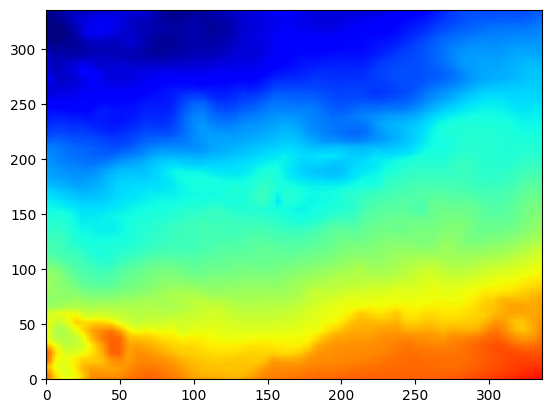

In [15]:
plt.pcolormesh(T2_ERA5, vmin=270, vmax=300, cmap=plt.cm.jet)

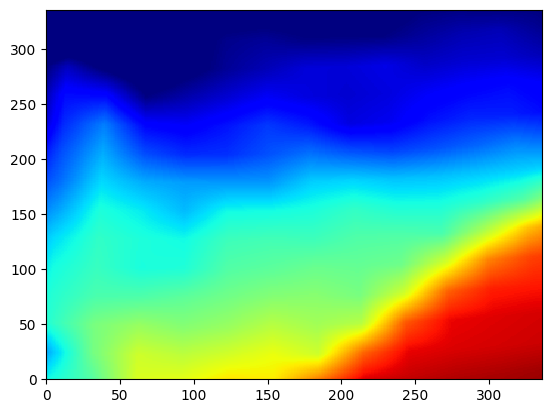

In [16]:
plt.pcolormesh(T2_CESM, vmin=270, vmax=300, cmap=plt.cm.jet)

In [33]:
Q_GDAS = ds_final['Q'].isel(time=1, level=5).values
Q_ERA5 = ds_ERA5['Q'].isel(time=6, level=5).values

In [28]:
Q_GDAS.max()

0.0038689417719031394

In [40]:
Q_GDAS.max()

0.01775666

In [45]:
T2_CESM.max()

299.28778

In [29]:
start = datetime(year, 1, 1)
end = datetime(year, 12, 31, 18)
dt_list = [start + i*timedelta(hours=6) for i in range(((end-start)//timedelta(hours=6)) + 1)]

fn_list = []
for dt in dt_list:
    month_dir = f"{year}.{dt:%m}"
    filename = dt.strftime("fnl_%Y%m%d_%H_%M.grib2")
    fn_list.append(os.path.join(base_dir, str(year), month_dir, filename))

In [30]:
fn_list[-1]

'/gdex/data/d083002/grib2/2024/2024.12/fnl_20241231_18_00.grib2'

In [31]:
ds_collection = []
N_ = 50

for i_fn, fn in enumerate(fn_list[:N_]):
    grbs = pygrib.open(fn)
    
    # Peek first grib that has a grid to get lat/lon shape
    # (Some messages may be spectral, but FNL/analyses are usually on regular_ll)
    sample = grbs.message(1)
    lats, lons = sample.latlons()
    ny, nx = lats.shape
    
    # Preallocate arrays
    iso_shape = (len(levels_Pa), ny, nx)
    U = np.full(iso_shape, np.nan, dtype=np.float32)
    V = np.full(iso_shape, np.nan, dtype=np.float32)
    T = np.full(iso_shape, np.nan, dtype=np.float32)
    RH = np.full(iso_shape, np.nan, dtype=np.float32)
    
    MSLP = np.full((ny, nx), np.nan, dtype=np.float32)
    U10  = np.full((ny, nx), np.nan, dtype=np.float32)
    V10  = np.full((ny, nx), np.nan, dtype=np.float32)
    T2 = np.full((ny, nx), np.nan, dtype=np.float32)
    
    # ----------------------------
    # 3) Scan messages and fill
    # ----------------------------
    # Build a fast lookup from hPa -> index
    lev2idx = {lev: i for i, lev in enumerate(levels_hPa)}
    
    grbs.rewind()
    for grb in grbs:
        name = grb.name                          # e.g., 'U component of wind'
        tlev = grb.typeOfLevel                   # e.g., 'isobaricInhPa', 'heightAboveGround', 'meanSea'
        level = grb.level                        # for isobaricInhPa: in hPa; for 10m: 10; for MSLP: 0
    
        # Isobaric 3-D variables
        if tlev == "isobaricInhPa" and level in lev2idx and name in want_isobaric:
            k = lev2idx[level]
            arr = grb.values.astype(np.float32, copy=False)
            if arr.shape != (ny, nx):
                # Safety check in case of unexpected grids
                continue
            short = want_isobaric[name]
            if   short == "U": U[k, :, :]  = arr
            elif short == "V": V[k, :, :]  = arr
            elif short == "T": T[k, :, :]  = arr
            elif short == "RH": RH[k, :, :] = arr
            continue
    
        # 2-D surface/near-surface variables
        key = (name, tlev, level)
        if key in want_surface:
            short = want_surface[key]
            arr = grb.values.astype(np.float32, copy=False)
            if arr.shape != (ny, nx):
                continue
            if   short == "MSL": MSLP[:, :] = arr
            elif short == "VAR_10U":  U10[:, :]  = arr
            elif short == "VAR_10V":  V10[:, :]  = arr
            elif short == "VAR_2T": T2[:, :]  = arr
    
    grbs.close()

    if i_fn == 0:
        coords = {
            "level": ("level", levels_Pa, {"long_name": "pressure", "units": "Pa"}),
            "y": ("y", np.arange(ny, dtype=np.int32)),
            "x": ("x", np.arange(nx, dtype=np.int32)),
            "latitude": (("y", "x"), lats.astype(np.float32)),
            "longitude": (("y", "x"), lons.astype(np.float32)),
        }
    
    ds = xr.Dataset(
        data_vars={
            "U":   (("level", "y", "x"), U,  {"long_name": "U wind", "units": "m s-1", "standard_name": "eastward_wind"}),
            "V":   (("level", "y", "x"), V,  {"long_name": "V wind", "units": "m s-1", "standard_name": "northward_wind"}),
            "T":   (("level", "y", "x"), T,  {"long_name": "Temperature", "units": "K", "standard_name": "air_temperature"}),
            "RH":  (("level", "y", "x"), RH, {"long_name": "Relative humidity", "units": "%"}),
            "MSL": (("y", "x"), MSLP, {"long_name": "Pressure reduced to MSL", "units": "Pa"}),
            "VAR_10U":  (("y", "x"), U10,  {"long_name": "10 m U wind", "units": "m s-1"}),
            "VAR_10V":  (("y", "x"), V10,  {"long_name": "10 m V wind", "units": "m s-1"}),
            "VAR_2T":  (("y", "x"), T2,  {"long_name": "10 m V wind", "units": "m s-1"}),
        },
        coords=coords,
        attrs={"source": "Converted from GRIB2 via pygrib"}
    )
    
    # Optional: set CF-ish axis attributes (useful for downstream tools)
    ds["y"].attrs["axis"] = "Y"
    ds["x"].attrs["axis"] = "X"
    ds["latitude"].attrs.update({"units": "degrees_north"})
    ds["longitude"].attrs.update({"units": "degrees_east"})
    
    # ======================================================== #
    # Interpolation block
    ds['longitude'] = (ds['longitude']  + 180) % 360 - 180
    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    
    if i_fn == 0:
        regridder = xe.Regridder(ds, ds_WRF_static, method='bilinear')
    
    ds_ERA5_interp = regridder(ds)
    
    ds_ERA5_interp = ds_ERA5_interp.assign_coords(
        south_north=domain_inds, 
        west_east=domain_inds
    )
    
    ds_ERA5_interp = ds_ERA5_interp.drop_vars(['lon', 'lat'])
    ds_ERA5_interp['level'] = ds_ERA5_interp['level']/100
    
    ds_collection.append(ds_ERA5_interp)

ds_year = xr.concat(ds_collection, dim='time')
ds_year = ds_year.assign_coords(time=np.array(dt_list[:N_], dtype="datetime64[ns]"))

# convert RH to Q
q = rh_to_q(ds_year["RH"], ds_year["T"], ds_year["level"])
q = q.astype("float32")
ds_year = ds_year.assign(Q=q)
ds_year = ds_year.chunk({'time': 12, 'level': 11, 'south_north': 336, 'west_east': 336})

save_name = f'/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_GDAS/GDAS_GP_1h_{year}.zarr'
# ds_year.to_zarr(save_name, mode='w', consolidated=True, compute=True)
print(save_name)

/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_GDAS/GDAS_GP_1h_2024.zarr


Community Earth System Model v2 Large Ensemble (CESM2 LENS)

https://gdex.ucar.edu/datasets/d010092/#

`/gdex/data/d651056/CESM2-LE/atm/proc/tseries/hour_6`

In [32]:
ds_gdas = ds_year

In [33]:
# ds_gdas = xr.open_dataset(save_name)

In [35]:
ds_ERA5 = xr.open_zarr('/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/dscale_1h/ERA5_GP_1h_2024.zarr')

In [45]:
Q_GDAS = ds_gdas['Q'].isel(time=1, level=0).values
Q_ERA5 = ds_ERA5['Q'].isel(time=6, level=0).values

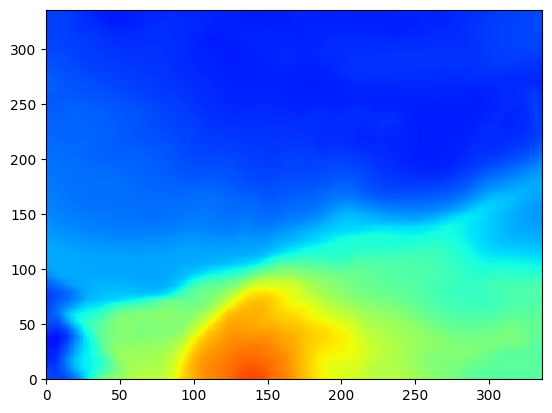

In [46]:
plt.pcolormesh(Q_ERA5, vmin=0, vmax=0.015, cmap=plt.cm.jet)

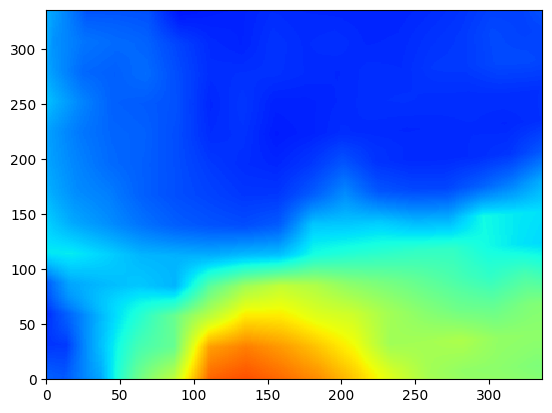

In [48]:
plt.pcolormesh(Q_GDAS, vmin=0, vmax=0.015, cmap=plt.cm.jet)

In [50]:
MSL_GDAS = ds_gdas['MSL'].isel(time=1,).values
MSL_ERA5 = ds_ERA5['MSL'].isel(time=6,).values

In [52]:
MSL_ERA5

array([[101886.016, 101886.   , 101886.03 , ..., 102240.66 , 102241.76 ,
        102243.   ],
       [101887.16 , 101887.63 , 101888.16 , ..., 102239.81 , 102240.89 ,
        102242.09 ],
       [101888.24 , 101889.22 , 101890.234, ..., 102238.95 , 102240.016,
        102241.17 ],
       ...,
       [102579.73 , 102581.586, 102583.42 , ..., 102190.945, 102185.15 ,
        102179.375],
       [102575.74 , 102577.54 , 102579.44 , ..., 102188.83 , 102182.93 ,
        102177.07 ],
       [102571.77 , 102573.48 , 102575.586, ..., 102186.68 , 102180.7  ,
        102174.74 ]], dtype=float32)

In [51]:
MSL_GDAS

array([[101872.01 , 101872.266, 101872.53 , ..., 102200.46 , 102201.14 ,
        102201.87 ],
       [101873.99 , 101874.266, 101874.55 , ..., 102199.83 , 102200.53 ,
        102201.29 ],
       [101875.97 , 101876.266, 101876.56 , ..., 102199.2  , 102199.93 ,
        102200.72 ],
       ...,
       [102602.125, 102618.22 , 102634.34 , ..., 102126.95 , 102120.93 ,
        102114.92 ],
       [102596.66 , 102613.   , 102629.38 , ..., 102124.32 , 102118.26 ,
        102112.21 ],
       [102591.15 , 102607.76 , 102624.516, ..., 102121.68 , 102115.58 ,
        102109.48 ]], dtype=float32)

In [42]:
T2_GDAS = ds_gdas['VAR_2T'].isel(time=1,).values
T2_ERA5 = ds_ERA5['VAR_2T'].isel(time=6,).values

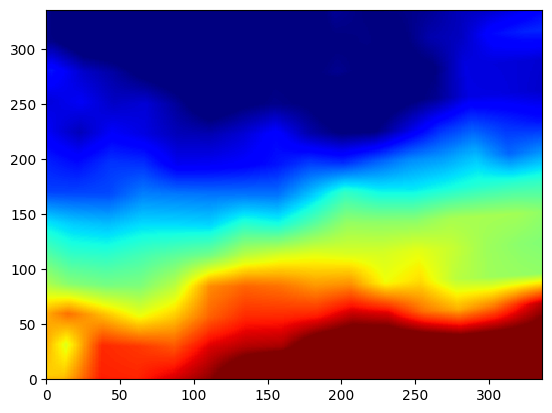

In [43]:
plt.pcolormesh(T2_GDAS, vmin=270, vmax=290, cmap=plt.cm.jet)

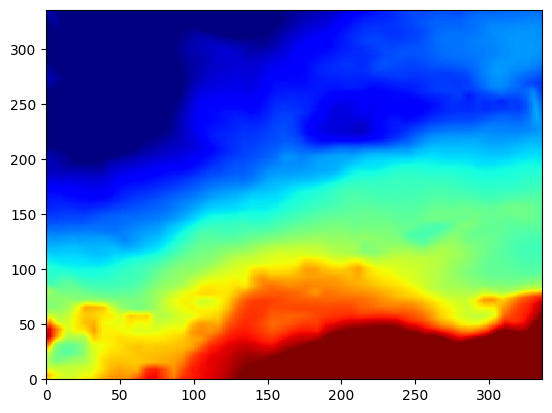

In [44]:
plt.pcolormesh(T2_ERA5, vmin=270, vmax=290, cmap=plt.cm.jet)

In [13]:
# import pygrib
# impport numpy as np

# # the title of grib variable names
# grb_names = [
#     'Pressure reduced to MSL:Pa (instant):regular_ll:meanSea:level 0',
#     '10 metre U wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m',
#     '10 metre V wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m',
# ]

# for p in 100*np.array([1000, 950, 850, 700, 600, 500, 400, 300, 200, 100, 50]):
#     grb_names += [
#         f'U component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level {p} Pa',
#         f'V component of wind:m s**-1 (instant):regular_ll:isobaricInhPa:level {p} Pa',
#         f'Temperature:K (instant):regular_ll:isobaricInhPa:level {p} Pa',
#         f'Relative humidity:% (instant):regular_ll:isobaricInhPa:level {p} Pa'
#     ]


# # grib2 file
# fn = '/gdex/data/d083002/grib2/2020/2020.01/fnl_20200101_00_00.grib2'
# grbs = pygrib.open(fn)

# # find the index of each variable name, pull variables, and save as an xr.dataset
# for grb in grbs:
#     print(grb)  # Prints information about each GRIB message